### Setup and imports


In [1]:
import numpy as np
import random
import math
import os
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error



### Utilities

In [2]:

def convert_to_time(hmm):
    hmm = [int(x.item() if isinstance(x, np.ndarray) and x.size == 1 else int(x)) for x in hmm]
    year, month, day, hour, minute, second = hmm
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)

def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_list = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}

        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0]
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l

        type_val = col[i][0][0]
        temp_val = col[i][1][0]
        time_val = col[i][2][0]

        if isinstance(type_val, np.ndarray) and type_val.size == 1:
            type_val = type_val.item()
        if isinstance(temp_val, np.ndarray) and temp_val.size == 1:
            temp_val = temp_val.item()

        d1['type'] = str(type_val)
        d1['temp'] = int(temp_val)
        d1['time'] = str(convert_to_time(time_val))
        d1['data'] = d2

        data_list.append(d1)

    return data_list

def getBatteryInputs(Battery, feature_list=None, include_temp=True):
    inputs = []

    if feature_list is None:
        for Bat in Battery:
            if Bat['type'] == 'discharge':
                feature_list = list(Bat['data'].keys())
                if 'Capacity' in feature_list:
                    feature_list.remove('Capacity')
                break

    if include_temp:
        feature_list.append('temp')

    all_data = []
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            row = []
            for f in feature_list:
                if f == 'temp':
                    row.append(Bat['temp'])
                else:
                    row.append(Bat['data'].get(f, [0])[0])
            all_data.append(row)
    all_data = np.array(all_data, dtype=np.float32)

    is_constant = np.all(all_data == all_data[0, :], axis=0)
    cleaned_data = all_data[:, ~is_constant]
    cleaned_feature_list = [f for f, keep in zip(feature_list, ~is_constant) if keep]

    return cleaned_data, cleaned_feature_list

def getBatteryCapacity(Battery):
    capacities = []
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacities.append(Bat['data']['Capacity'][0])
    return np.array(capacities, dtype=np.float32)


### Data Processing

In [3]:
# Load batteries

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = 'dataset/'

Battery_dict = {}
for name in Battery_list:
    print(f'Loading {name}')
    path = dir_path + name + '.mat'
    data = loadMat(path)

    X, feature_list = getBatteryInputs(data)
    y = getBatteryCapacity(data)
    Battery_dict[name] = (X, y)


# Sliding window + scaling

window_size = 15

X_all_windows = []
y_all_windows = []
battery_ids = []

y_scalers = {}  # per-battery scaler
x_scalers = {}  # per-battery scaler

for b_idx, (name, (X, y)) in enumerate(Battery_dict.items()):
    X_diff = np.diff(X, axis=0, prepend=X[0:1,:])
    cycle_idx = np.arange(len(X)).reshape(-1,1)/len(X)
    y_prev = np.roll(y,1).reshape(-1,1); y_prev[0]=y[0]
    cum_discharge = np.cumsum(X[:,1]).reshape(-1,1)
    temp_diff = np.diff(X[:,2], prepend=X[0,2:3]).reshape(-1,1)
    
    X_combined = np.hstack([X, X_diff, cycle_idx, y_prev, cum_discharge, temp_diff])
    
    battery_feat = np.full((len(X_combined),1), b_idx)
    X_combined = np.hstack([X_combined, battery_feat])
    
    x_scaler = MinMaxScaler()
    X_scaled = x_scaler.fit_transform(X_combined)
    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y.reshape(-1,1))
    
    x_scalers[name] = x_scaler
    y_scalers[name] = y_scaler
    
    for i in range(len(X_scaled)-window_size):
        X_all_windows.append(X_scaled[i:i+window_size])
        y_all_windows.append(y_scaled[i+window_size,0])
        battery_ids.append(b_idx)

X_all_windows = np.array(X_all_windows)
y_all_windows = np.array(y_all_windows)
split_idx = int(0.6*len(X_all_windows))
X_train, X_test = X_all_windows[:split_idx], X_all_windows[split_idx:]
y_train, y_test = y_all_windows[:split_idx], y_all_windows[split_idx:]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)



Loading B0005
Loading B0006
Loading B0007
Loading B0018


### Transformer model

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:,:x.size(1), :]

class BatteryTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2,
                 dim_feedforward=128, dropout=0.1, last_frac=0.4, last_weight=3.0):
        super().__init__()
        self.input_proj = nn.Linear(num_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(d_model, 1)

        self.last_frac = last_frac
        self.last_weight = last_weight

    def forward(self, x):
        seq_len = x.size(1)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.encoder(x)

        weights = torch.ones(seq_len, device=x.device)
        last_start = int(seq_len * (1 - self.last_frac))
        weights[last_start:] = self.last_weight
        weights = weights / weights.sum()

        x = (x * weights.unsqueeze(1)).sum(dim=1)
        x = self.dropout(x)
        return self.regressor(x).squeeze(-1)

model = BatteryTransformer(num_features=X_train_t.shape[-1],
                           d_model=128, nhead=4, num_layers=2,
                           dim_feedforward=256, dropout = 0.1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.HuberLoss()



### Training loop with early stopping

In [5]:
epochs = 500
patience = 50
best_loss = float('inf')
trigger_times = 0
best_state = None

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_t)
        test_loss = criterion(y_test_pred, y_test_t).item()

    if test_loss < best_loss - 1e-6:
        best_loss = test_loss
        best_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1

    if (epoch + 1) % 25 == 0 or trigger_times == patience:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.6f} | Test Loss: {test_loss:.6f}")

    if trigger_times >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Restored best model with test loss: {best_loss:.6f}")

model.eval()



Epoch 25/500 | Train Loss: 0.042910 | Test Loss: 0.059086
Epoch 50/500 | Train Loss: 0.008666 | Test Loss: 0.007095
Epoch 75/500 | Train Loss: 0.005764 | Test Loss: 0.004549
Epoch 100/500 | Train Loss: 0.005124 | Test Loss: 0.004241
Epoch 125/500 | Train Loss: 0.002694 | Test Loss: 0.003207
Epoch 150/500 | Train Loss: 0.002202 | Test Loss: 0.003179
Epoch 175/500 | Train Loss: 0.002061 | Test Loss: 0.003239
Epoch 200/500 | Train Loss: 0.001589 | Test Loss: 0.003033
Epoch 225/500 | Train Loss: 0.001235 | Test Loss: 0.002696
Epoch 250/500 | Train Loss: 0.001391 | Test Loss: 0.002362
Epoch 275/500 | Train Loss: 0.001241 | Test Loss: 0.002798
Epoch 300/500 | Train Loss: 0.001132 | Test Loss: 0.002385
Epoch 317/500 | Train Loss: 0.001251 | Test Loss: 0.002473
Early stopping triggered at epoch 317
Restored best model with test loss: 0.002173


BatteryTransformer(
  (input_proj): Linear(in_features=13, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (regressor): Linear(in_features=128, out_features=1, bias=True)
)


### Prediction, RMSE, plotting per battery

Battery B0005 | RMSE: 0.0168 Ah | MAE: 0.0136 Ah | MAPE: 0.0089


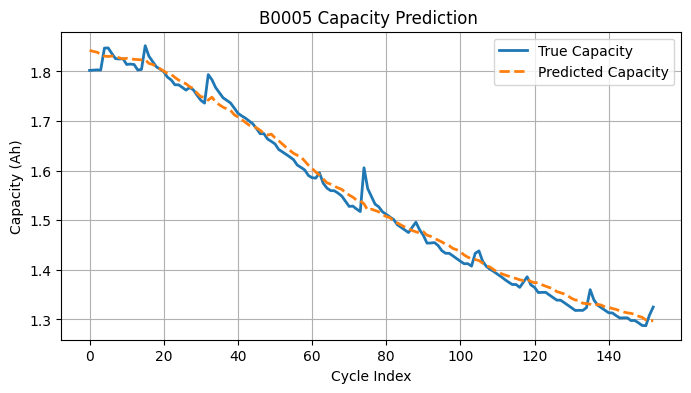

Battery B0006 | RMSE: 0.0368 Ah | MAE: 0.0292 Ah | MAPE: 0.0188


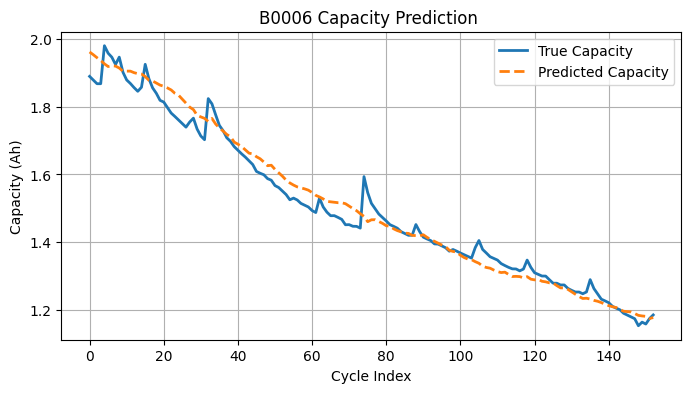

Battery B0007 | RMSE: 0.0152 Ah | MAE: 0.0108 Ah | MAPE: 0.0065


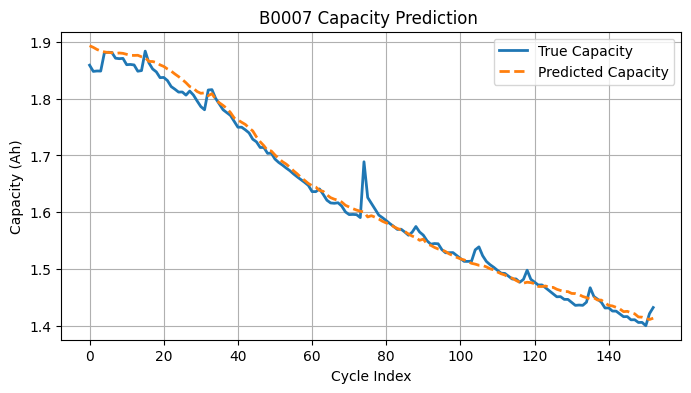

Battery B0018 | RMSE: 0.0489 Ah | MAE: 0.0423 Ah | MAPE: 0.0283


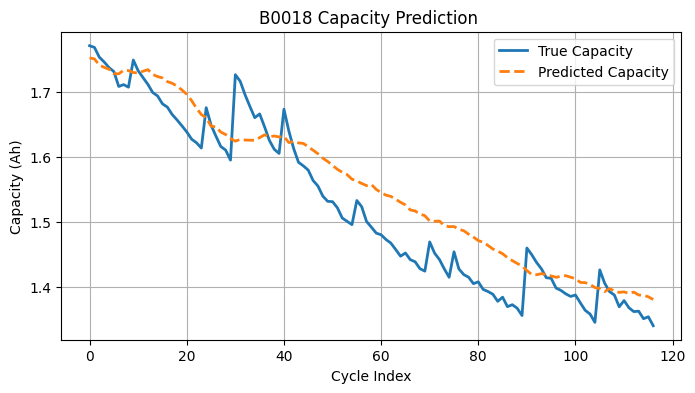

In [6]:
battery_transformer_preds = {}

for b_idx, (name, (X, y)) in enumerate(Battery_dict.items()):
    X_diff = np.diff(X, axis=0, prepend=X[0:1,:])
    cycle_idx = np.arange(len(X)).reshape(-1,1)/len(X)
    y_prev = np.roll(y,1).reshape(-1,1); y_prev[0]=y[0]
    cum_discharge = np.cumsum(X[:,1]).reshape(-1,1)
    temp_diff = np.diff(X[:,2], prepend=X[0,2:3]).reshape(-1,1)

    battery_feat = np.full((len(X),1), b_idx)
    X_combined = np.hstack([X, X_diff, cycle_idx, y_prev, cum_discharge, temp_diff, battery_feat])
    X_scaled = x_scalers[name].transform(X_combined)

    preds_scaled = []
    for i in range(len(X_scaled)-window_size):
        x_win = torch.tensor(X_scaled[i:i+window_size], dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            p = model(x_win).cpu().numpy()
        preds_scaled.append(p)

    preds_scaled = np.array(preds_scaled).ravel()
    y_true = y[window_size:]
    preds = y_scalers[name].inverse_transform(preds_scaled.reshape(-1,1)).ravel()

    rmse = np.sqrt(mean_squared_error(y_true, preds))
    mae = mean_absolute_error(y_true, preds)
    mape = mean_absolute_percentage_error(y_true, preds)
    print(f"Battery {name} | RMSE: {rmse:.4f} Ah | MAE: {mae:.4f} Ah | MAPE: {mape:.4f}")

    plt.figure(figsize=(8,4))
    plt.plot(y_true, label='True Capacity', linewidth=2)
    plt.plot(preds, '--', label='Predicted Capacity', linewidth=2)
    plt.title(f'{name} Capacity Prediction ')
    plt.xlabel('Cycle Index')
    plt.ylabel('Capacity (Ah)')
    plt.legend()
    plt.grid(True)
    plt.show()

    battery_transformer_preds[name] = {
        "true": y_true,
        "preds": preds
    }
